ADULT DATASET : **RANDOM FOREST**

To see the preprocessing in detail open "0_Adult_Preprocessing_all_models.ipynb"

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [233]:
#!unzip adult.zip

In [234]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv("adult.data", header = None, names = col_names)
print(df.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50

In [235]:
#income == 1 if income >= 50K , income == = if income < 50K
def income_map(income):
    if isinstance(income, str):  # Controlla se il valore è una stringa
        income = income.strip()  # Rimuove eventuali spazi bianchi prima e dopo il valore
        if income == ">50K":
            return 1
    return 0

df["income"] = df["income"].map(income_map)


In [236]:
#check if the dataset is balanced
df.income.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

In [237]:
#check for duplicate rows
duplicates = df.duplicated(keep = False)
print(f"duplicate rows: {duplicates.sum()}")

duplicate rows: 47


In [238]:
#remove
df.drop_duplicates(inplace = True)
duplicates = df.duplicated(keep = False)
print(f"duplicate rows: {duplicates.sum()}")

duplicate rows: 0


In [239]:
#split
df_train, df_test = train_test_split(df, test_size = 0.2, shuffle = True, random_state=42, stratify = df["income"])

In [240]:
#null values in train
#print("Null Train")
#print(df_train.isna().sum())

In [241]:
#null values in test
#print("Null Test")
#print(df_test.isna().sum())

Let's see what values ​​each column contains, to understand how and whether to discretize, normalize or encode

In [242]:
for column in df.columns:
    unique_values = set(df[column])
    print(f"values in column '{column}': {unique_values}")


values in column 'age': {17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90}
values in column 'workclass': {' Local-gov', ' ?', ' Never-worked', ' Self-emp-not-inc', ' Federal-gov', ' Self-emp-inc', ' Private', ' Without-pay', ' State-gov'}
values in column 'fnlwgt': {262153, 262158, 131088, 131091, 393248, 131117, 393264, 262196, 262208, 262233, 262241, 262244, 262245, 131178, 131180, 262280, 393354, 393357, 262285, 393360, 131224, 131230, 393376, 131239, 131258, 262345, 131275, 262352, 131288, 131298, 131302, 131309, 131310, 262402, 393480, 262409, 262425, 262439, 262446, 131379, 262478, 131414, 131417, 131425, 131435, 262511, 262515, 131459, 131461, 131463, 131473, 262552, 262570, 131519, 262601, 393673, 131534, 262617, 131552, 131568, 393712, 262

AGE , maybe better do nothing

In [243]:
print((set(df_train["age"])))

{17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90}


WORKCLASS

In [244]:
print((set(df["workclass"])))


{' Local-gov', ' ?', ' Never-worked', ' Self-emp-not-inc', ' Federal-gov', ' Self-emp-inc', ' Private', ' Without-pay', ' State-gov'}


In [245]:
# Rename "?" con "Unknown" in "workclass"
df_train['workclass'] = df_train['workclass'].replace(' ?', ' Unknown')
df_test['workclass'] = df_test['workclass'].replace(' ?', ' Unknown')

In [246]:
# Combine "Federal-gov", "State-gov" e "Local-gov" e rename in "Government"
df_train.loc[df_train["workclass"].isin([" Federal-gov", " State-gov", " Local-gov"]), "workclass"] = " Government"
df_test.loc[df_test["workclass"].isin([" Federal-gov", " State-gov", " Local-gov"]), "workclass"] = " Government"

# Combine "Self-emp-inc", "Self-emp-not-inc" e rename in "Self-emp"
df_train.loc[df_train["workclass"].isin([" Self-emp-inc", " Self-emp-not-inc"]), "workclass"] = " Self-emp"
df_test.loc[df_test["workclass"].isin([" Self-emp-inc", " Self-emp-not-inc"]), "workclass"] = " Self-emp"

In [247]:
print((set(df_train["workclass"])))

{' Never-worked', ' Government', ' Self-emp', ' Private', ' Without-pay', ' Unknown'}


FNLWGH rescale

In [248]:
from sklearn.preprocessing import MinMaxScaler
minmax_s = MinMaxScaler()
minmax_s.fit(df_train[['fnlwgt']])
df_train['fnlwgt'] = minmax_s.transform(df_train[['fnlwgt']])
df_test['fnlwgt'] = minmax_s.transform(df_test[['fnlwgt']])

EDUCATION combination of features

In [249]:
list1 = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', 'HS-grad', 'Some-college']
df_train['education'] = df_train['education'].str.strip()
df_train.loc[df_train["education"].isin(list1), "education"] = "Non Graduated"

df_test['education'] = df_test['education'].str.strip()
df_test.loc[df_test["education"].isin(list1), "education"] = "Non Graduated"


list2 = ["Assoc-voc", "Assoc-acdm", "Bachelors"]
df_train['education'] = df_train['education'].str.strip()
df_train.loc[df_train["education"].isin(list2), "education"] = "Bachelor's Degree"

df_test['education'] = df_test['education'].str.strip()
df_test.loc[df_test["education"].isin(list2), "education"] = "Bachelor's Degree"


list3 = ["Masters", "Prof-school"]
df_train['education'] = df_train['education'].str.strip()
df_train.loc[df_train["education"].isin(list3), "education"] = "Master's Degree"

df_test['education'] = df_test['education'].str.strip()
df_test.loc[df_test["education"].isin(list3), "education"] = "Master's Degree"


list4 = ["Doctorate"]
df_train['education'] = df_train['education'].str.strip()
df_train.loc[df_train["education"].isin(list4), "education"] = "Doctorate Degree"

df_test['education'] = df_test['education'].str.strip()
df_test.loc[df_test["education"].isin(list4), "education"] = "Doctorate Degree"

In [250]:
#to fix a problem
list5 = ["12th"]
df_train['education'] = df_train['education'].str.strip()
df_train.loc[df_train["education"].isin(list5), "education"] = "Non Graduated"

df_test['education'] = df_test['education'].str.strip()
df_test.loc[df_test["education"].isin(list5), "education"] = "Non Graduated"



In [251]:
print((set(df_train["education"])))

{"Master's Degree", "Bachelor's Degree", 'Non Graduated', 'Doctorate Degree'}


In [252]:
print((set(df_test["education"])))

{"Bachelor's Degree", "Master's Degree", 'Non Graduated', 'Doctorate Degree'}


EDUCATION NUM, I can work on, but maybe I will drop this column beacuse I think that is highly correlated with education

In [253]:
print((set(df_test["education-num"])))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


MARITAL STATUS
we will have: ' Never-married', Married = ' Married-spouse-absent', ' Married-civ-spouse', ' Married-AF-spouse', ' Separated', ' Divorced' and ' Widowed'

In [254]:
# Combine ' Married-spouse-absent', ' Married-civ-spouse', ' Married-AF-spouse' e rename in "Married"
df_train.loc[df_train["marital-status"].isin([' Married-spouse-absent', ' Married-civ-spouse', ' Married-AF-spouse']), "marital-status"] = " Married"
df_test.loc[df_test["marital-status"].isin([' Married-spouse-absent', ' Married-civ-spouse', ' Married-AF-spouse']), "marital-status"] = " Married"



In [255]:
print((set(df_test["marital-status"])))

{' Separated', ' Never-married', ' Married', ' Widowed', ' Divorced'}


OCCUPATION
I suppose that is highly correlated with workclass, so I combine in something similar to workclass and i will check if it is really high correlated

In [256]:
print((set(df_test["occupation"])))

{' Craft-repair', ' Handlers-cleaners', ' ?', ' Farming-fishing', ' Armed-Forces', ' Exec-managerial', ' Machine-op-inspct', ' Prof-specialty', ' Transport-moving', ' Protective-serv', ' Priv-house-serv', ' Other-service', ' Sales', ' Adm-clerical', ' Tech-support'}


In [257]:
# Rename "?" con "Unknown" in "occupation"
df_train['occupation'] = df_train['occupation'].replace(' ?', ' Unknown')
df_test['occupation'] = df_test['occupation'].replace(' ?', ' Unknown')

In [258]:
# Government-occ
list1 = ['Armed-Forces', 'Protective-serv', 'Adm-clerical', 'Transport-moving']
df_train['occupation'] = df_train['occupation'].str.strip()
df_train.loc[df_train["occupation"].isin(list1), "occupation"] = " Government-occ"
df_test['occupation'] = df_test['occupation'].str.strip()
df_test.loc[df_test["occupation"].isin(list1), "occupation"] = " Government-occ"
#Private-occ
list2 = ['Exec-managerial', 'Priv-house-serv', 'Handlers-cleaners', 'Sales' ]
df_train['occupation'] = df_train['occupation'].str.strip()
df_train.loc[df_train["occupation"].isin(list2), "occupation"] = " Private-occ"
df_test['occupation'] = df_test['occupation'].str.strip()
df_test.loc[df_test["occupation"].isin(list2), "occupation"] = " Private-occ"
#Self-emp-occ
list3 = ['Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'Craft-repair' ]
df_train['occupation'] = df_train['occupation'].str.strip()
df_train.loc[df_train["occupation"].isin(list3), "occupation"] = " Self-emp-occ"
df_test['occupation'] = df_test['occupation'].str.strip()
df_test.loc[df_test["occupation"].isin(list3), "occupation"] = " Self-emp-occ"

In [259]:
print((set(df_test["occupation"])))

{'Private-occ', 'Prof-specialty', 'Government-occ', 'Other-service', 'Unknown', ' Self-emp-occ'}


RELATIONSHIP
I suppose that it could be correlated with marital status

In [260]:
print((set(df_test['relationship'])))

{' Wife', ' Other-relative', ' Husband', ' Unmarried', ' Own-child', ' Not-in-family'}


RACE

In [261]:
print((set(df_test['race'])))

{' White', ' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Other', ' Black'}


SEX

In [262]:
print((set(df_test['sex'])))

{' Female', ' Male'}


CAPITAL GAIN rescale

In [263]:
print((set(df_test['capital-gain'])))

{0, 2050, 4101, 7688, 14344, 2062, 2580, 3103, 1055, 25124, 2597, 4650, 18481, 2105, 5178, 3137, 2635, 4687, 594, 20051, 5721, 3674, 2653, 2174, 1151, 2176, 7298, 25236, 99999, 9386, 15024, 4787, 27828, 2228, 6849, 3781, 13550, 2290, 3325, 4865, 14084, 7430, 2829, 6418, 10520, 4386, 1831, 2346, 3887, 2354, 1848, 4416, 3908, 2885, 10566, 4934, 5455, 3411, 2387, 2907, 6497, 3942, 2407, 10605, 2414, 6514, 2936, 1409, 3464, 3471, 401, 914, 2964, 5013, 4508, 11678, 2463, 8614, 5556, 1471, 6097, 991, 4064, 1506, 2036}


In [264]:
from sklearn.preprocessing import MinMaxScaler
minmax_s = MinMaxScaler()
minmax_s.fit(df_train[['capital-gain']])
df_train['capital-gain'] = minmax_s.transform(df_train[['capital-gain']])
df_test['capital-gain'] = minmax_s.transform(df_test[['capital-gain']])

CAPITAL LOSS as before

In [265]:
print((set(df_test['capital-loss'])))

{0, 1408, 2051, 2179, 4356, 1669, 1672, 2824, 2444, 1564, 2205, 2206, 1825, 419, 2339, 1573, 2467, 810, 1579, 2603, 1590, 1719, 1848, 1977, 1974, 1594, 1340, 1980, 1721, 1726, 3770, 2238, 1602, 1092, 2377, 1740, 1485, 1741, 2001, 2258, 1617, 1876, 213, 2002, 2129, 2392, 1628, 1887, 1504, 1762, 1380, 2149, 1902, 2415, 880, 625, 1138, 2547, 1651, 2042, 2174, 2559}


In [266]:
from sklearn.preprocessing import MinMaxScaler
minmax_s = MinMaxScaler()
minmax_s.fit(df_train[['capital-loss']])
df_train['capital-loss'] = minmax_s.transform(df_train[['capital-loss']])
df_test['capital-loss'] = minmax_s.transform(df_test[['capital-loss']])

HOURS PER WEEK nothing

In [267]:
print((set(df_test['hours-per-week'])))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 72, 75, 76, 77, 78, 80, 84, 85, 90, 96, 98, 99}


NATIVE COUNTRY
I think could be highly correlated with race , so I make some transformations

In [268]:
print((set(df_test['native-country'])))

{' Guatemala', ' Ireland', ' Philippines', ' Peru', ' Scotland', ' Greece', ' Yugoslavia', ' Portugal', ' Columbia', ' Laos', ' India', ' Haiti', ' Puerto-Rico', ' Canada', ' Hungary', ' South', ' Cuba', ' Trinadad&Tobago', ' Ecuador', ' China', ' Mexico', ' Vietnam', ' Dominican-Republic', ' France', ' Outlying-US(Guam-USVI-etc)', ' Nicaragua', ' Cambodia', ' Iran', ' Poland', ' Germany', ' Honduras', ' ?', ' United-States', ' Japan', ' Jamaica', ' Hong', ' El-Salvador', ' Thailand', ' England', ' Taiwan', ' Italy'}


In [269]:
# Rename "?" con "Unknown" in "native-country"
df_train['native-country'] = df_train['native-country'].replace(' ?', ' Unknown')
df_test['native-country'] = df_test['native-country'].replace(' ?', ' Unknown')

In [270]:
#caucasian/white
list1 = ['Germany', 'England', 'Scotland', 'France', 'Italy', 'Ireland', 'Greece', 'Poland', 'Portugal', 'Yugoslavia', 'Hungary']
df_train['native-country'] = df_train['native-country'].str.strip()
df_train.loc[df_train["native-country"].isin(list1), "native-country"] = " Caucasian-White"
df_test['native-country'] = df_test['native-country'].str.strip()
df_test.loc[df_test["native-country"].isin(list1), "native-country"] = " Caucasian-White"

#african american/black
list2 = ['United-States', 'Jamaica', 'Haiti', 'Trinadad&Tobago']
df_train['native-country'] = df_train['native-country'].str.strip()
df_train.loc[df_train["native-country"].isin(list2), "native-country"] = " African-American-Black"
df_test['native-country'] = df_test['native-country'].str.strip()
df_test.loc[df_test["native-country"].isin(list2), "native-country"] = " African-American-Black"

#latino/hispanic
list3 = ['Peru', 'Mexico', 'Puerto-Rico', 'Guatemala', 'Honduras', 'El-Salvador', 'Nicaragua', 'Cuba', 'Dominican-Republic', 'Columbia', 'Ecuador']
df_train['native-country'] = df_train['native-country'].str.strip()
df_train.loc[df_train["native-country"].isin(list3), "native-country"] = " Latino-Hispanic"
df_test['native-country'] = df_test['native-country'].str.strip()
df_test.loc[df_test["native-country"].isin(list3), "native-country"] = " Latino-Hispanic"

#Asian
list4 = ['Thailand', 'Philippines', 'Vietnam', 'China', 'Japan', 'India', 'Taiwan', 'Cambodia', 'Laos' ]
df_train['native-country'] = df_train['native-country'].str.strip()
df_train.loc[df_train["native-country"].isin(list4), "native-country"] = " Asian"
df_test['native-country'] = df_test['native-country'].str.strip()
df_test.loc[df_test["native-country"].isin(list4), "native-country"] = " Asian"

#Other
list5 = ['Outlying-US(Guam-USVI-etc)', 'Iran', 'Unknown', 'Canada', 'South', 'Hong', 'Israel', 'Lebanon', 'Holand-Netherlands', 'Romania', 'Russia', 'Switzerland', 'Scotland'  ]
df_train['native-country'] = df_train['native-country'].str.strip()
df_train.loc[df_train["native-country"].isin(list5), "native-country"] = " Other"
df_test['native-country'] = df_test['native-country'].str.strip()
df_test.loc[df_test["native-country"].isin(list5), "native-country"] = " Other"


In [271]:
print((set(df_train['native-country'])))

{' Other', 'Asian', 'African-American-Black', 'Caucasian-White', 'Latino-Hispanic'}


In [272]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24764,33,Private,0.181258,Non Graduated,9,Married,Prof-specialty,Husband,White,Male,0.000000,0.000000,60,African-American-Black,0
9890,59,Private,0.176095,Non Graduated,10,Married,Self-emp-occ,Husband,White,Male,0.150242,0.000000,50,African-American-Black,1
2754,80,Self-emp,0.116848,Non Graduated,4,Married,Self-emp-occ,Husband,White,Male,0.000000,0.000000,30,African-American-Black,0
5298,33,Private,0.059664,Non Graduated,9,Married,Government-occ,Wife,White,Female,0.000000,0.399449,25,African-American-Black,0
2593,39,Private,0.206117,Master's Degree,14,Never-married,Private-occ,Not-in-family,Black,Male,0.086141,0.000000,52,African-American-Black,1


ENCODING
Label Encoding

In [273]:
#df_train.info()
#df_test.info()


In [274]:
categorical_cols = [1, 3, 5, 6, 7, 8, 9, 13]

In [275]:
df_train_enc = df_train.copy()
df_test_enc = df_test.copy()

In [276]:
categorical_names = {}
le_dict = {}

for feature in categorical_cols:
    le = LabelEncoder()
    transformed_values = le.fit_transform(df_train_enc.iloc[:, feature])
    df_train_enc.iloc[:, feature] = transformed_values
    categorical_names[feature] = le.classes_
    le_dict[feature] = le

for feature, classes in categorical_names.items():
    print(f'Feature {feature}: ')
    print('Encoded values: ', list(range(len(classes))))
    print('Original values: ', classes)
    print()

# Per le colonne non categoriche
non_categorical_cols = [col for col in df_train_enc.columns if col not in categorical_cols]
for col in non_categorical_cols:
    le = LabelEncoder()
    transformed_values = le.fit_transform(df_train_enc[col])
    df_train_enc[col] = transformed_values


Feature 1: 
Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Government' ' Never-worked' ' Private' ' Self-emp' ' Unknown'
 ' Without-pay']

Feature 3: 
Encoded values:  [0, 1, 2, 3]
Original values:  ["Bachelor's Degree" 'Doctorate Degree' "Master's Degree" 'Non Graduated']

Feature 5: 
Encoded values:  [0, 1, 2, 3, 4]
Original values:  [' Divorced' ' Married' ' Never-married' ' Separated' ' Widowed']

Feature 6: 
Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Self-emp-occ' 'Government-occ' 'Other-service' 'Private-occ'
 'Prof-specialty' 'Unknown']

Feature 7: 
Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']

Feature 8: 
Encoded values:  [0, 1, 2, 3, 4]
Original values:  [' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']

Feature 9: 
Encoded values:  [0, 1]
Original values:  [' Female' ' Male']

Feature 13: 
Encoded values:  [0, 1, 2, 3, 4]
Original values: 

In [277]:
original_labels_dict = {
    'workclass': ['Government', 'Never-worked', 'Private', 'Self-emp', 'Unknown', 'Without-pay'],
    'education': ["Bachelor's Degree", 'Doctorate Degree', "Master's Degree", 'Non Graduated'],
    'marital-status': ['Divorced', 'Married', 'Never-married', 'Separated', 'Widowed'],
    'occupation': ['Self-emp-occ', 'Government-occ', 'Other-service', 'Private-occ', 'Prof-specialty', 'Unknown'],
    'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'],
    'race': ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'],
    'sex': ['Female', 'Male'],
    'native-country': ['Other', 'African-American-Black', 'Asian', 'Caucasian-White', 'Latino-Hispanic']
}
def get_original_label(column_name, encoded_value):
    return original_labels_dict[column_name][encoded_value]

In [278]:
#print(df_train_enc.info())

In [279]:
categorical_names_test = {}
le_dict_test = {}

for feature in categorical_cols:
    le = le_dict[feature]
    transformed_values = le.transform(df_test_enc.iloc[:, feature])
    df_test_enc.iloc[:, feature] = transformed_values
    categorical_names_test[feature] = le.classes_
    le_dict_test[feature] = le

for feature, classes in categorical_names_test.items():
    print(f'Feature {feature}: ')
    print()
    print('Encoded values: ', list(range(len(classes))))
    print('Original values: ', classes)

# Per le colonne non categoriche
non_categorical_cols = [col for col in df_test_enc.columns if col not in categorical_cols]
for col in non_categorical_cols:
    le = LabelEncoder()
    transformed_values = le.fit_transform(df_test_enc[col])
    df_test_enc[col] = transformed_values


Feature 1: 

Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Government' ' Never-worked' ' Private' ' Self-emp' ' Unknown'
 ' Without-pay']
Feature 3: 

Encoded values:  [0, 1, 2, 3]
Original values:  ["Bachelor's Degree" 'Doctorate Degree' "Master's Degree" 'Non Graduated']
Feature 5: 

Encoded values:  [0, 1, 2, 3, 4]
Original values:  [' Divorced' ' Married' ' Never-married' ' Separated' ' Widowed']
Feature 6: 

Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Self-emp-occ' 'Government-occ' 'Other-service' 'Private-occ'
 'Prof-specialty' 'Unknown']
Feature 7: 

Encoded values:  [0, 1, 2, 3, 4, 5]
Original values:  [' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
Feature 8: 

Encoded values:  [0, 1, 2, 3, 4]
Original values:  [' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
Feature 9: 

Encoded values:  [0, 1]
Original values:  [' Female' ' Male']
Feature 13: 

Encoded values:  [0, 1, 2, 3, 4]
Original values:

In [280]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26029 entries, 24764 to 5372
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             26029 non-null  int64  
 1   workclass       26029 non-null  object 
 2   fnlwgt          26029 non-null  float64
 3   education       26029 non-null  object 
 4   education-num   26029 non-null  int64  
 5   marital-status  26029 non-null  object 
 6   occupation      26029 non-null  object 
 7   relationship    26029 non-null  object 
 8   race            26029 non-null  object 
 9   sex             26029 non-null  object 
 10  capital-gain    26029 non-null  float64
 11  capital-loss    26029 non-null  float64
 12  hours-per-week  26029 non-null  int64  
 13  native-country  26029 non-null  object 
 14  income          26029 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 3.2+ MB
None


In [281]:
print(df_train_enc.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26029 entries, 24764 to 5372
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             26029 non-null  int64
 1   workclass       26029 non-null  int64
 2   fnlwgt          26029 non-null  int64
 3   education       26029 non-null  int64
 4   education-num   26029 non-null  int64
 5   marital-status  26029 non-null  int64
 6   occupation      26029 non-null  int64
 7   relationship    26029 non-null  int64
 8   race            26029 non-null  int64
 9   sex             26029 non-null  int64
 10  capital-gain    26029 non-null  int64
 11  capital-loss    26029 non-null  int64
 12  hours-per-week  26029 non-null  int64
 13  native-country  26029 non-null  int64
 14  income          26029 non-null  int64
dtypes: int64(15)
memory usage: 3.2 MB
None


By analyzing the correlation, it seems that only education and education-num are highly correlated (both linear and non linear correlation)
Sex and relationship are correlated, but if I remove one of them I can lose informations

In [282]:
df_train.drop('education', axis = 1, inplace = True)
df_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24764,33,Private,0.181258,9,Married,Prof-specialty,Husband,White,Male,0.000000,0.000000,60,African-American-Black,0
9890,59,Private,0.176095,10,Married,Self-emp-occ,Husband,White,Male,0.150242,0.000000,50,African-American-Black,1
2754,80,Self-emp,0.116848,4,Married,Self-emp-occ,Husband,White,Male,0.000000,0.000000,30,African-American-Black,0
5298,33,Private,0.059664,9,Married,Government-occ,Wife,White,Female,0.000000,0.399449,25,African-American-Black,0
2593,39,Private,0.206117,14,Never-married,Private-occ,Not-in-family,Black,Male,0.086141,0.000000,52,African-American-Black,1


In [283]:
df_test.drop('education', axis = 1, inplace = True)
df_test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20334,27,Private,0.113028,14,Never-married,Self-emp-occ,Not-in-family,White,Female,0.0,0.0,40,African-American-Black,0
23878,51,Government,0.254659,13,Married,Government-occ,Husband,White,Male,0.0,0.0,50,African-American-Black,1
19996,34,Private,0.129184,8,Married,Other-service,Husband,White,Male,0.0,0.0,40,Latino-Hispanic,0
21440,31,Private,0.082569,12,Divorced,Private-occ,Not-in-family,White,Male,0.0,0.0,40,African-American-Black,0
10000,34,Private,0.073468,10,Divorced,Government-occ,Not-in-family,White,Female,0.0,0.0,50,African-American-Black,0


FINE PREPROCESSING 
Algoritmi ML: Random Forest

In [284]:
X_train = df_train.drop(columns = 'income', axis = 1)
y_train = df_train['income']

X_test = df_test.drop(columns = 'income', axis = 1)
y_test = df_test['income']

In [285]:
X_train_enc = df_train_enc.drop(columns = 'income', axis = 1)
y_train_enc = df_train_enc['income']


In [286]:
X_test_enc = df_test_enc.drop(columns = 'income', axis = 1)
y_test_enc = df_test_enc['income']


FINE PREPROCESSING

RANDOM FOREST

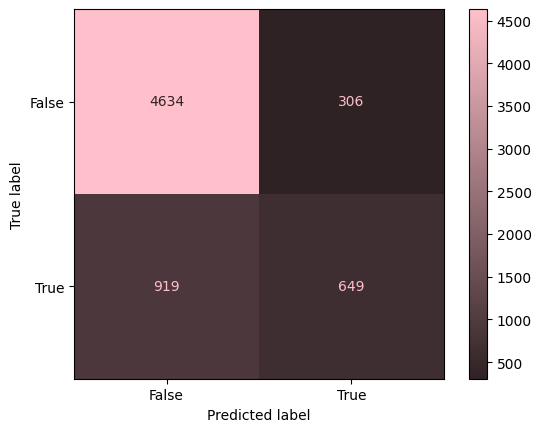

In [287]:

cmap = sns.dark_palette("pink", as_cmap=True)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_enc, y_train_enc)
y_pred_rf = rf.predict(X_test_enc)
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[False, True])
disp.plot(cmap=cmap)
plt.show()



In [288]:
print(classification_report(y_test_enc, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4940
           1       0.68      0.41      0.51      1568

    accuracy                           0.81      6508
   macro avg       0.76      0.68      0.70      6508
weighted avg       0.80      0.81      0.79      6508



In [289]:
tn, fp, fn, tp = cm_rf.ravel()

accuracy = accuracy_score(y_test_enc, y_pred_rf)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Create a DataFrame
metrics_rf = pd.DataFrame({
    'Accuracy': [accuracy],
    'False Positive Rate': [false_positive_rate],
    'False Negative Rate': [false_negative_rate],
    'False Positives': [fp],
    'False Negatives': [fn]
})

In [290]:
metrics_rf


,Accuracy,False Positive Rate,False Negative Rate,False Positives,False Negatives
0,0.81177,0.061943,0.586097,306,919


SUBGROUPS SEARCH

In [291]:
#! pip install divexplorer

In [292]:
from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
from divexplorer.outcomes import get_false_positive_rate_outcome

For every model (here Random Forest):

-I define pandas df which contains: X_test, y_test, y_pred by the model;

-I apply DivExplorer on such dataset NOT ENCODED and with a discretization of age;

-I see how the false positive rate changes in the subgroups w.r.t. the overall dataset;

-Compute e plot local/global shapley values

Let's make some modify on the data: let's discretize 'age'

In [293]:
bins = [0, 25, 35, 45, 65, 90, float('inf')]  # Aggiunto float('inf') per gestire i valori oltre 90
labels = ['<25', '26-35', '36-45', '46-65', '66-90', 'Outside Range']


df_train['age_group'] = pd.cut(df_train['age'], bins=bins, labels=labels, right=False)
df_train = df_train.drop(columns=['age']).rename(columns={'age_group': 'age'})

df_test['age_group'] = pd.cut(df_test['age'], bins=bins, labels=labels, right=False)
df_test = df_test.drop(columns=['age']).rename(columns={'age_group': 'age'})



In [294]:
df_test_rf = df_test.copy()
df_test_rf['y_test'] = y_test
df_test_rf['y_pred_rf'] = y_pred_rf
df_test_rf.head(5)

,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age,y_test,y_pred_rf
20334,Private,0.113028,14,Never-married,Self-emp-occ,Not-in-family,White,Female,0.0,0.0,40,African-American-Black,0,26-35,0,0
23878,Government,0.254659,13,Married,Government-occ,Husband,White,Male,0.0,0.0,50,African-American-Black,1,46-65,1,1
19996,Private,0.129184,8,Married,Other-service,Husband,White,Male,0.0,0.0,40,Latino-Hispanic,0,26-35,0,0
21440,Private,0.082569,12,Divorced,Private-occ,Not-in-family,White,Male,0.0,0.0,40,African-American-Black,0,26-35,0,0
10000,Private,0.073468,10,Divorced,Government-occ,Not-in-family,White,Female,0.0,0.0,50,African-American-Black,0,26-35,0,0


In [295]:
y_trues = df_test_rf["y_test"]
y_preds = df_test_rf["y_pred_rf"]

df_test_rf['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)
df_test_rf[100:102]

,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age,y_test,y_pred_rf,fp
4154,Private,0.089498,16,Married,Prof-specialty,Husband,White,Male,0.0,0.0,55,African-American-Black,1,26-35,1,1,NaN
19357,Private,0.210716,13,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,45,African-American-Black,0,26-35,0,0,0.0


In [296]:
fp_diver = DivergenceExplorer(df_test_rf)


attributes = ['age', 'workclass', 'sex', 'race', 'hours-per-week']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.05, attributes=attributes,
                                        boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)

FP_fm.head(5)


,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.064997,"(sex= Male, race= White, hours-per-week=50)",0.200000,0.138057,5.124323,3,423.0
1,0.071143,"(sex= Male, hours-per-week=50)",0.198312,0.136369,5.317404,2,463.0
2,0.175630,"(sex= Male, race= White, age=46-65)",0.179081,0.117138,7.541868,3,1143.0
3,0.105101,"(sex= Male, workclass= Private, race= White, age=46-65)",0.178756,0.116813,5.975405,4,684.0
4,0.197910,"(sex= Male, age=46-65)",0.168975,0.107032,7.503031,2,1288.0


The subgroup with highest false-positive rate is (race = White, sex = Male, hours-per-week = 50) , and they have a false positive rate of 
0.200,
which is 13.80% above the average false-positive rate. 
There are 423 instances in this subgroup.

In [297]:

print(f"Recall that the False Positive Rate for the overall Random Forest was: {false_positive_rate:.4f}" )

Recall that the False Positive Rate for the overall Random Forest was: 0.0619


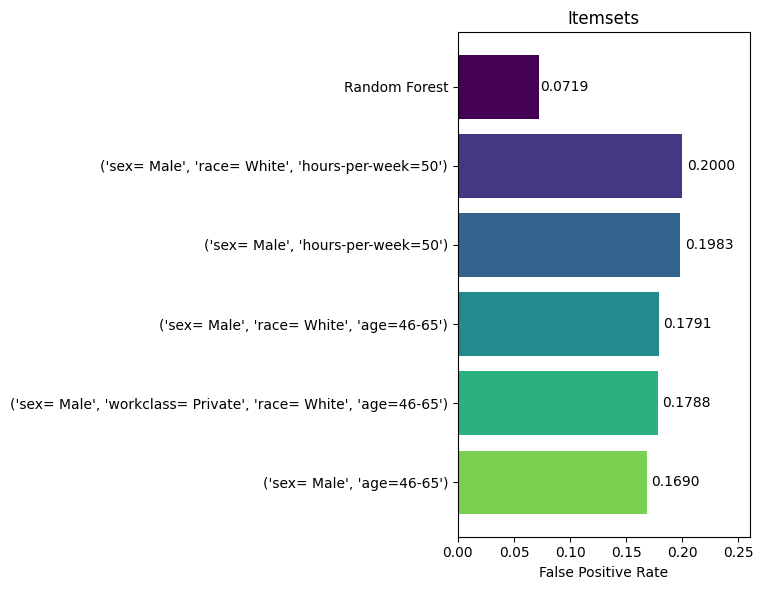

In [298]:
#PLOT
top_5_fp_fm = FP_fm.head(5)

# GB data
model_fp = 0.0719
model_label = "Random Forest"

# data for plot
fp_data = [(model_label, model_fp)] + list(top_5_fp_fm[['itemset', 'fp']].itertuples(index=False, name=None))

# order
sorted_fp_data = sorted(fp_data[1:], key=lambda x: x[1], reverse=True)
sorted_fp_data.insert(0, fp_data[0])

# extract itemset and values
sorted_fp_values = [item[1] for item in sorted_fp_data]
sorted_itemsets = [item[0] for item in sorted_fp_data]

# Colors
num_colors = len(sorted_fp_values)
colors = plt.cm.viridis(np.linspace(0, 0.8, num_colors))

# Graph
plt.figure(figsize=(8, 6))
bars = plt.barh(np.arange(len(sorted_itemsets)), sorted_fp_values, color=colors)
plt.yticks(np.arange(len(sorted_itemsets)), [str(itemset).replace("frozenset", "").replace("{", "").replace("}", "") for itemset in sorted_itemsets])
plt.xlabel('False Positive Rate')
plt.title('Itemsets')

# Add fp values
for i, fp_value in enumerate(sorted_fp_values):
    plt.text(fp_value * 1.02, i, f'{fp_value:.4f}', va='center', ha='left')

plt.tight_layout()
plt.gca().invert_yaxis()
plt.xlim(right=max(sorted_fp_values) * 1.3)
plt.show()

In [299]:
fp_details = DivergencePatternProcessor(FP_fm, 'fp')

pattern = fp_details.patterns['itemset'].iloc[0]
#print(pattern)
sv = fp_details.shapley_value(pattern)
#sv

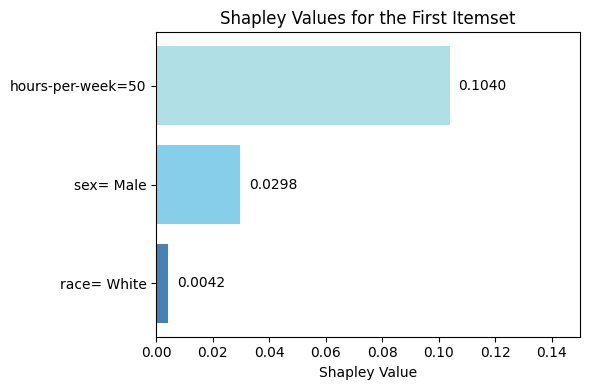

In [300]:
sorted_sv = sorted(sv.values(), reverse=True)
sorted_keys = sorted(sv, key=sv.get, reverse=True)

# Drop 'frozenset'
sorted_keys_labels = [', '.join(item) for item in sorted_keys]

# Colour
colors = ['#B0E0E6', '#87CEEB', '#4682B4', '#7FFFD4', '#40E0D0', '#AFEEEE', '#E0FFFF', '#F0FFFF']

# Graph
plt.figure(figsize=(6, 4))
bars = plt.barh(np.arange(len(sorted_sv)), sorted_sv, color=colors[:len(sorted_sv)])
plt.yticks(np.arange(len(sorted_sv)), sorted_keys_labels)
plt.xlabel('Shapley Value')
plt.title('Shapley Values for the First Itemset')

# Add shapley values
for i, value in enumerate(sorted_sv):
    plt.text(value + 0.003, i, f'{value:.4f}', va='center', ha='left', color='black')  # 0.003 corrisponde a circa 3 mm

plt.gca().invert_yaxis()  #desc order
plt.xlim(0, 0.15)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()




In [301]:
gsv = fp_details.global_shapley_value()
#gsv

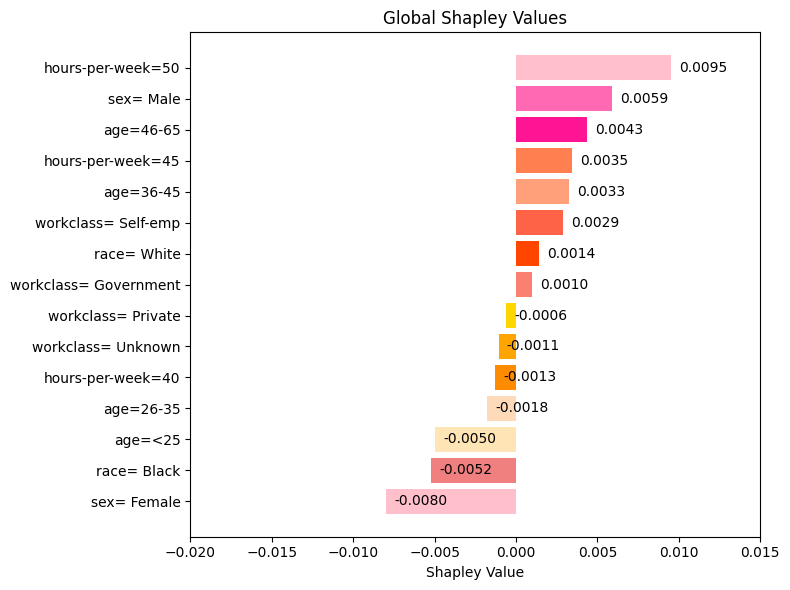

In [302]:

#order gsv desc
sorted_gsv = sorted(gsv.items(), key=lambda x: x[1], reverse=True)

# extract itemset and Shapley values
itemsets = [' '.join(item) for item, value in sorted_gsv]
shapley_values = [value for item, value in sorted_gsv]

# Colours
colors = ['#FFC0CB', '#FF69B4', '#FF1493', '#FF7F50', '#FFA07A', '#FF6347', '#FF4500', '#FA8072', '#FFD700', '#FFA500', '#FF8C00', '#FFDAB9', '#FFE4B5', '#F08080']

# Graph of Shapley values
plt.figure(figsize=(8, 6))
bars = plt.barh(itemsets, shapley_values, color=colors[:len(itemsets)])
plt.xlabel('Shapley Value')
plt.title('Global Shapley Values')

# Add numbers
for i, value in enumerate(shapley_values):
    plt.text(value + 0.0005, i, format(value, '.4f'), va='center', ha='left', color='black')

plt.gca().invert_yaxis() 
plt.xlim(-0.020, 0.015)
plt.tight_layout()
plt.show()


**BIAS MITIGATION**

Approach number one: post-hoc mitigation.

Let's train the model on a sub-set of the initial data 
        --> let's add "problematica" data
                --> let's see if the false positive rate changes

In [303]:
#train on the 70% of training data
X_train_subset, X_val_enc, y_train_subset, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.3, random_state=42)
rf.fit(X_train_subset, y_train_subset)

y_val_pred = rf.predict(X_val_enc)
accuracy_val = accuracy_score(y_val_enc, y_val_pred)
print("Accuracy sul validation set: ", accuracy_val)


#compute false positive rate by using the validation set
cm = confusion_matrix(y_val_enc, y_val_pred)
FP = cm[0,1]
TN = cm[0,0]
FPR_val = FP / (FP+TN)
print("False positive rate on validation set: ", FPR_val)

Accuracy sul validation set:  0.8449225252913305
False positive rate on validation set:  0.07957957957957958


In [304]:
#Let's find the itemsets on the validation set

#create the dataframe with X_val_enc attributes + y_val_enc and y_val_pred
df_val_div = X_val_enc.copy()
df_val_div['y_val_enc'] = y_val_enc
df_val_div['y_val_pred'] = y_val_pred
df_val_div.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y_val_enc,y_val_pred
11397,24,3,1708,3,8,0,0,1,4,1,0,0,54,1,0,0


In [305]:
df_val_div['fp'] =  get_false_positive_rate_outcome(y_val_enc, y_val_pred)
fp_diver = DivergenceExplorer(df_val_div)

attributes = ['age', 'workclass', 'sex', 'race', 'hours-per-week']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.05, attributes=attributes,
                                        boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
FP_fm.head(5)

,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.067614,"(sex=1, hours-per-week=49, race=4)",0.198582,0.119002,5.044882,3,528.0
1,0.068639,"(sex=1, workclass=0, race=4)",0.197605,0.118025,5.429298,3,536.0
2,0.071456,"(sex=1, hours-per-week=49)",0.190635,0.111056,4.919532,2,558.0
3,0.082853,"(sex=1, workclass=0)",0.171569,0.091989,4.921130,2,647.0
4,0.081957,"(hours-per-week=49, race=4)",0.162983,0.083404,4.313321,2,640.0


On the train set, let's add "some" rows with data (hours-per-week=49, sex = 1, race = 4,  workclass = 0) and see how the false positive rate changes on the validation.
In paricular I add NEW_ROWS rows with such values, for the other attributes I add the most frequent value and because of the problem is the FP rate, y_train_enc must be = 0 fot this new rows

HERE I ADD AN ARBITRARY NUMBER OF ROWS AND I SEE HOW THE FPR CHANGES, 
The new rows have the couple feature/value for the problematic itemset inspected and the most frequent value for the other features

In [306]:
NUM_ROWS = 200

#new rows dataframe 
new_rows = pd.DataFrame({
    'age': X_train_subset['age'].mode()[0], 
    'workclass': X_train_subset['workclass'].mode()[0], 
    'fnlwgt': X_train_subset['fnlwgt'].mode()[0],  
    'education': X_train_subset['education'].mode()[0], 
    'education-num': X_train_subset['education-num'].mode()[0],  
    'marital-status': X_train_subset['marital-status'].mode()[0],  
    'occupation': X_train_subset['occupation'].mode()[0],  
    'relationship': X_train_subset['relationship'].mode()[0],  
    'race': 4,  
    'sex': 1, 
    'capital-gain': X_train_subset['capital-gain'].mode()[0],  
    'capital-loss': X_train_subset['capital-loss'].mode()[0],  
    'hours-per-week': 49,  
    'native-country': X_train_subset['native-country'].mode()[0], 
}, index=np.arange(len(X_train_subset), len(X_train_subset) + NUM_ROWS))

# Aggiunta delle nuove righe al DataFrame originale
X_train_subset = pd.concat([X_train_subset, new_rows])
y_train_subset = np.concatenate([y_train_subset, np.zeros(NUM_ROWS)])


In [307]:
rf.fit(X_train_subset, y_train_subset)

y_val_pred = rf.predict(X_val_enc)
accuracy_val = accuracy_score(y_val_enc, y_val_pred)
print("Accuracy on validation set: ", accuracy_val)


#compute false positive rate by using the validation set
cm = confusion_matrix(y_val_enc, y_val_pred)
FP = cm[0,1]
TN = cm[0,0]
new_FPR_val = FP / (FP+TN)
print("False positive rate on validation set when train set is augmented: ", new_FPR_val)
print()
print("Before, FPR: ", FPR_val)

Accuracy on validation set:  0.8462030989883468
False positive rate on validation set when train set is augmented:  0.07841174507841174

Before, FPR:  0.07957957957957958


Same as before, but here: 
                --> I choose a false positive rate reduction target 
                --> non-problematic values ​​are inserted by sampling from the data distribution

In [231]:
#Parameters
NUM_ROWS = 10
TARGET_REDUCTION = 0.03
PRINT_INTERVAL = 50
np.random.seed(42)

#sampling function
def sample_attribute(attribute, condition):
    return np.random.choice(X_train_subset[condition][attribute].values, NUM_ROWS, replace=True)

#FPR computation
def calculate_fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]
    TN = cm[0, 0]
    return FP / (FP + TN)

#sex and race fixed: they belong to the problematic itemset
condition = (X_train_subset['sex'] == 1) & (X_train_subset['race'] == 4)

# Training
dt = DecisionTreeClassifier()
dt.fit(X_train_subset, y_train_subset)
y_val_pred = dt.predict(X_val_enc)
initial_FPR_val = calculate_fpr(y_val_enc, y_val_pred)
print("Initial false positive rate on validation set: ", initial_FPR_val)


X_train_augmented = X_train_subset.copy()
y_train_augmented = y_train_subset.copy()


total_added_rows = 0

# Add rows
while True:
    new_rows = pd.DataFrame({
        'age': sample_attribute('age', condition), 
        'workclass': sample_attribute('fnlwgt', condition),  
        'fnlwgt': sample_attribute('fnlwgt', condition),  
        'education': sample_attribute('education', condition), 
        'education-num': sample_attribute('education-num', condition),  
        'marital-status': sample_attribute('marital-status', condition),  
        'occupation': sample_attribute('occupation', condition),  
        'relationship': sample_attribute('relationship', condition),  
        'race': [4] * NUM_ROWS,  
        'sex': [1] * NUM_ROWS,  
        'capital-gain': sample_attribute('capital-gain', condition),  
        'capital-loss': sample_attribute('capital-loss', condition),  
        'hours-per-week': [49] * NUM_ROWS,
        'native-country': sample_attribute('native-country', condition)
    }, index=np.arange(len(X_train_augmented), len(X_train_augmented) + NUM_ROWS))

    
    X_train_augmented = pd.concat([X_train_augmented, new_rows])
    y_train_augmented = np.concatenate([y_train_augmented, np.zeros(NUM_ROWS)])
    
    
    total_added_rows += NUM_ROWS
    
    # Training 
    dt.fit(X_train_augmented, y_train_augmented)
    y_val_pred = dt.predict(X_val_enc)
    
    #New FPR
    new_FPR_val = calculate_fpr(y_val_enc, y_val_pred)
    

    if total_added_rows % PRINT_INTERVAL == 0:
        print(f"After adding {total_added_rows} rows:")
        print("Current false positive rate on validation set: ", new_FPR_val)
    
    #check if the target is reached
    if new_FPR_val <= initial_FPR_val * (1 - TARGET_REDUCTION):
        break

#final results
accuracy_val = accuracy_score(y_val_enc, y_val_pred)
print("Final accuracy on validation set: ", accuracy_val)
print("Initial FPR: ", initial_FPR_val)
print("Final FPR: ", new_FPR_val)
print("Total added rows: ", total_added_rows)

Initial false positive rate on validation set:  0.13129796463129798
After adding 50 rows:
Current false positive rate on validation set:  0.13513513513513514
After adding 100 rows:
Current false positive rate on validation set:  0.1324657991324658
After adding 150 rows:
Current false positive rate on validation set:  0.1324657991324658
After adding 200 rows:
Current false positive rate on validation set:  0.1359693026359693
After adding 250 rows:
Current false positive rate on validation set:  0.13780447113780447
After adding 300 rows:
Current false positive rate on validation set:  0.13930597263930597
After adding 350 rows:
Current false positive rate on validation set:  0.1324657991324658
After adding 400 rows:
Current false positive rate on validation set:  0.13747080413747081
After adding 450 rows:
Current false positive rate on validation set:  0.13163163163163163
After adding 500 rows:
Current false positive rate on validation set:  0.13463463463463463
After adding 550 rows:
Curr